## 목적
- bayes-opt로 찾아낸 best parameter로 모델을 학습하고 6월 prediction

## Process
1. bayesian optimization 에서 나온 결과 확인 후, parameter selection
2. 해당 parameter를 가지고 5월 데이터를 사용해 모델 학습
    - 이번에는 sampling 된 데이터 사용
    - 추후에는 전수 사용? -> 모델 성능 향상 여부 확인 필요
3. 모델이 이상하지 않은지 3월 데이터로 evaluation
4. 6월 데이터 Prediction
5. 최종 serving 형태로 변환
6. load to hive -> insert to comm_dev

## Package

In [2]:
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import pickle
import os
import gc

import multiprocessing
import random
import time

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from bayes_opt import BayesianOptimization
from sm_utils import sampling, evaluate, save_model, load_model, make_train_data,  make_test_data

In [1]:
def test_different_period(clf, test_ym):
    print('test ym: ', test_ym)
    
    # load data
    print('load data')
    df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_{}.pkl'.format(test_ym)))
    print('df_mart: ', df_mart.shape)
    
    # make test data format
    print('make test data format')
    result = make_test_data(df_mart)
    idx = result['idx']
    x_test = result['x']
    y_test = result['y']
    feature_cols = list(x_test.columns)
    print('x_test: ', x_test.shape)
    print('y_test: ', y_test.shape)
    
    # evaluation
    print('evaluation')
    t1 = time.time()
    lgb_result_dict = evaluate(x_test, y_test.label.values, clf, 'lgb')
    print('elapsed time: ', time.time()-t1)

### 1. bayes-opt

In [2]:
df_res = pd.read_pickle('bayes_opt_for_may_input.pkl')

In [3]:
df_res.sort_values('target', ascending=False).head(20)

lambda_l1  lambda_l2  num_leaves    target
69   30.917645  99.936358  422.696252  0.860341
33   15.793345  99.998463  391.118795  0.860318
14    0.103445  99.542195  415.371497  0.860286
98   42.238359  71.947824  157.876910  0.860231
94    1.999530  99.997638  409.113329  0.860107
81   19.719437  99.837243  391.969473  0.860045
6    16.603305  94.696212  234.376056  0.859995
67   24.027153  99.784439  438.771280  0.859945
78   23.411270  99.967185  395.477808  0.859924
15    0.432567  99.986395  165.715206  0.859915
62   23.080114  99.987390  392.288780  0.859897
82   14.852933  99.855536  402.159466  0.859881
80   24.902044  99.851588  393.404896  0.859851
42   22.370460  99.962197  437.722146  0.859813
16    0.846087  99.940382  409.555937  0.859812
35   22.125586  99.803082  403.397406  0.859722
88   27.226133  99.958769  408.211496  0.859650
26   26.014650  99.959411  126.832604  0.859581
109  24.161689  99.896061  425.664462  0.859567
95    0.043322  99.017682  408.439361  0.859566

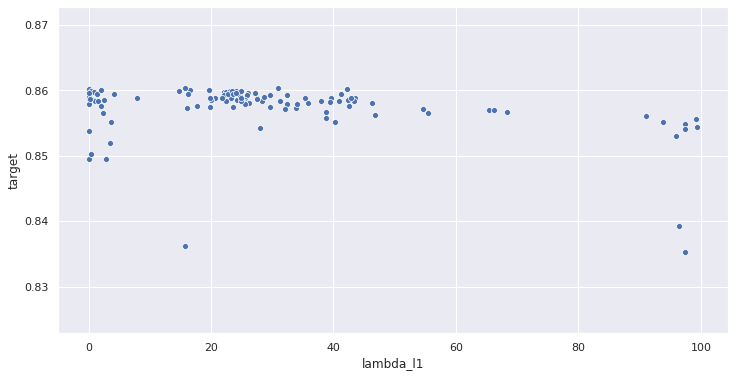

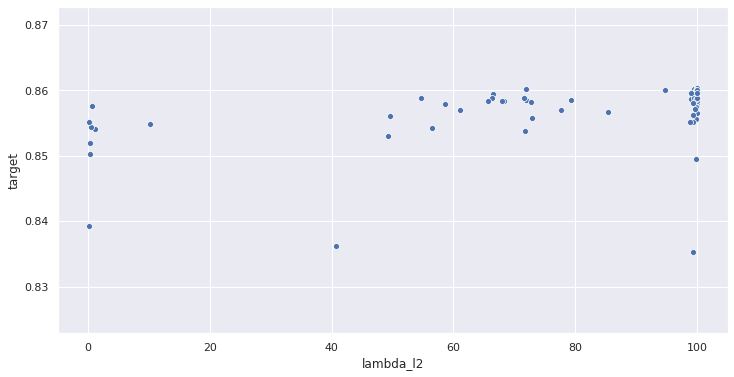

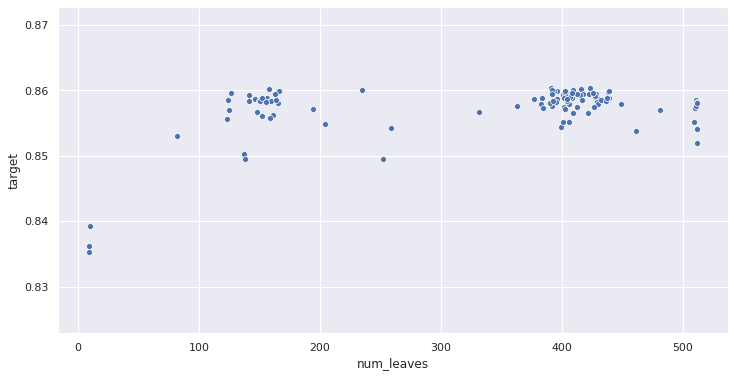

In [4]:
for col in df_res.columns:
    if col == 'target':
        continue
    
    sns.set(rc={'figure.figsize': (12,6)})
    sns.scatterplot(df_res[col], df_res['target'])
    plt.show()

- num_leaves가 너무 많으면 overfitting 느낌, 128로 맞춤

In [76]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 128,
    'lambda_l1': 25,
    'lambda_l2': 100,
    'learning_rate': 0.05,
    'num_threads': 40,
}

### 2. 5월 데이터로 training

In [8]:
DATA_PATH = '/home/dmig/work/upsell/data/'
RESULT_PATH = '/home/dmig/work/upsell/result/training_preriod/'


# load data
print('load data')
df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_{}.pkl'.format('201905')))
print('df_mart: ', df_mart.shape)


# make train data
result = make_train_data(df_mart)

trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']

val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

feature_cols = list(x_trn.columns)

lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

load data
df_mart:  (18707537, 81)
make_train_data +++
label/sample:  0.2
sample/total:  0.11652977086187241
make_data_for_modeling---


In [11]:
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=5000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.806542	valid_1's auc: 0.805236
[100]	training's auc: 0.821604	valid_1's auc: 0.819563
[150]	training's auc: 0.829954	valid_1's auc: 0.82694
[200]	training's auc: 0.835684	valid_1's auc: 0.83166
[250]	training's auc: 0.839952	valid_1's auc: 0.834848
[300]	training's auc: 0.842925	valid_1's auc: 0.836717
[350]	training's auc: 0.846091	valid_1's auc: 0.83906
[400]	training's auc: 0.84864	valid_1's auc: 0.8406
[450]	training's auc: 0.8507	valid_1's auc: 0.841664
[500]	training's auc: 0.852545	valid_1's auc: 0.842551
[550]	training's auc: 0.853971	valid_1's auc: 0.843079
[600]	training's auc: 0.855321	valid_1's auc: 0.843442
[650]	training's auc: 0.856723	valid_1's auc: 0.843968
[700]	training's auc: 0.858011	valid_1's auc: 0.844346
[750]	training's auc: 0.859317	valid_1's auc: 0.844709
[800]	training's auc: 0.860346	valid_1's auc: 0.844871
[850]	training's auc: 0.86186	valid_1's auc: 0.845542
[900]	traini

### 3. 3월 데이터로 evaluation

test ym:  201903
load data
df_mart:  (18580984, 81)
make test data format
x_test:  (18580984, 79)
y_test:  (18580984, 1)
evaluation
        acc   recall  precision  f1_score       auc
0  0.773941  0.77346   0.080012  0.145022  0.859928
                       feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       32931
6            last_equip_period           NaN       24416
5              svc_scrb_period           NaN       23602
1                          age            나이       15784
3              mng_nice_cb_scr     나이스 신용 점수       11970
53            data_usage_ratio           NaN       11346
9                  eqp_out_prc        단말 출고가       10688
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율        9976
48             real_arpu_bf_m3       순수 ARPU        9081
46             real_arpu_bf_m1       순수 ARPU        8828
7                  bas_fee_amt        요금제 가격        8349
49               real_avg_arpu       평균 ARPU        8266
27      data_usage_in_g

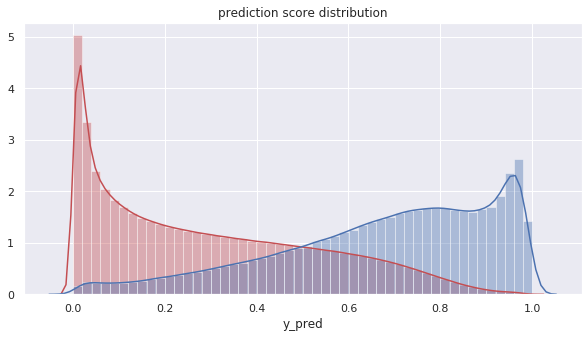

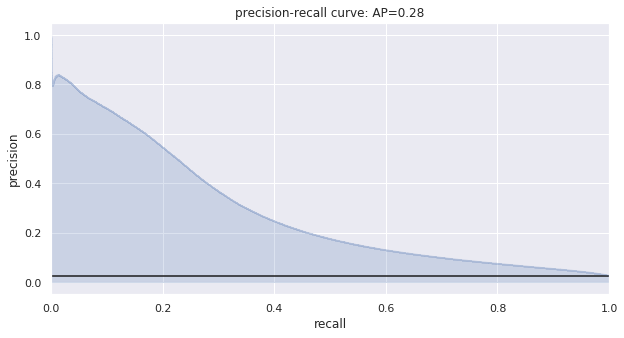

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/lgb_0709_102123.pkl
save model to  /home/dmig/work/upsell/result/lgb_0709_102123.pkl
elapsed time:  470.5212390422821


In [13]:
test_different_period(clf, '201903')

### 3-2. 600만 check

In [20]:
lgb_result_dict = pd.read_pickle('/home/dmig/work/upsell/result/lgb_0709_102123.pkl')
df_result = lgb_result_dict['result']

df_tmp1 = df_result.sort_values('y_pred', ascending=False).iloc[:6000000,:]
df_tmp2 = df_result.sort_values('y_pred', ascending=False).iloc[6000000:,:]
df_tmp1.y_pred_class = 1
df_tmp2.y_pred_class = 0
df_tmp = pd.concat([df_tmp1, df_tmp2])

In [29]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

y_true = df_tmp.y_true
y_pred = df_result.y_pred
y_pred_class = df_tmp.y_pred_class

df_metrics = pd.DataFrame({'acc': accuracy_score(y_true, y_pred_class),
                           'recall': recall_score(y_true, y_pred_class),
                           'precision': precision_score(y_true, y_pred_class),
                           'f1_score': f1_score(y_true, y_pred_class),
                           'auc': roc_auc_score(df_result.y_true, y_pred)}, index=[0])
display(df_metrics)

acc    recall  precision  f1_score       auc
0  0.694144  0.844028    0.06479  0.120342  0.859928

### save model

In [16]:
save_model(clf, '/home/dmig/work/upsell/result/final_model.pkl')

save model to  /home/dmig/work/upsell/result/final_model.pkl


In [17]:
clf.save_model('/home/dmig/work/upsell/result/final_model.txt')

In [19]:
import json 
model_json = clf.dump_model()
with open('/home/dmig/work/upsell/result/final_model.json', 'w+') as f:
    json.dump(model_json, f, indent=4)

In [6]:
clf = load_model('/home/dmig/work/upsell/model/final_model.pkl')

load model from  /home/dmig/work/upsell/model/final_model.pkl


In [7]:
clf

In [12]:
feature_cols = [c for c in df_mart06.columns if c != 'svc_mgmt_num']

In [13]:
len(feature_cols)

79

In [14]:
len(clf.feature_name())

79

### 4. 6월 prediction

In [3]:
df_mart06 = pd.read_pickle('/home/dmig/work/upsell/data/df_input_201906.pkl')

df_mart06.shape

(18855464, 80)

In [4]:
df_mart06.head()

svc_mgmt_num  sex_cd  age  svc_gr  mng_nice_cb_scr  mng_nice_cb_grd  \
0   1000181902       0   62       1              870                2   
1   1000249506       1   48       2              845                3   
2   1000439203       1   72       2              905                1   
3   1000868610       1   61       1              948                1   
4   1002110303       1   61       1              905                1   

   svc_scrb_period  last_equip_period  bas_fee_amt  bas_ofr_data_gb  ...  \
0             8556               1259        38500         0.537109  ...   
1             8411                538        65890        11.000000  ...   
2             8037               1175        32890         0.292969  ...   
3             6978               4422        12100         0.000100  ...   
4             7755                911        33000         1.000000  ...   

   mth_cnsl_cnt_bf_m0  mth_cnsl_cnt_bf_m1  mth_cnsl_cnt_bf_m2  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   1   

   dsat_cnsl_cnt_bf_m0  dsat_cnsl_cnt_bf_m1  dsat_cnsl_cnt_bf_m2  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   simpl_ref_cnsl_cnt_bf_m0  simpl_ref_cnsl_cnt_bf_m1  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   simpl_ref_cnsl_cnt_bf_m2  channel  
0                         0        3  
1                         0        1  
2                         0        3  
3                         0        3  
4                         1        3  

[5 rows x 80 columns]

In [8]:
df_score = df_mart06[['svc_mgmt_num']]

In [15]:
df_score['score'] = clf.predict(df_mart06[feature_cols])

/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
df_score.head()

svc_mgmt_num     score
0   1000181902  0.190743
1   1000249506  0.656178
2   1000439203  0.364433
3   1000868610  0.215469
4   1002110303  0.610405

In [18]:
import seaborn as sns

sns.distplot(df_score['score'])

In [20]:
df_score[df_score['svc_mgmt_num']=='7278902818']

svc_mgmt_num     score
15920   7278902818  0.923089

In [21]:
import shap

In [22]:
explainer = shap.TreeExplainer(clf)

In [24]:
df_mart06[df_mart06['svc_mgmt_num']=='7278902818']

svc_mgmt_num  sex_cd  age  svc_gr  mng_nice_cb_scr  mng_nice_cb_grd  \
15920   7278902818       0   63       1              909                1   

       svc_scrb_period  last_equip_period  bas_fee_amt  bas_ofr_data_gb  ...  \
15920              715                715            0           0.0001  ...   

       mth_cnsl_cnt_bf_m0  mth_cnsl_cnt_bf_m1  mth_cnsl_cnt_bf_m2  \
15920                   0                   0                   0   

       dsat_cnsl_cnt_bf_m0  dsat_cnsl_cnt_bf_m1  dsat_cnsl_cnt_bf_m2  \
15920                    0                    0                    0   

       simpl_ref_cnsl_cnt_bf_m0  simpl_ref_cnsl_cnt_bf_m1  \
15920                         0                         0   

       simpl_ref_cnsl_cnt_bf_m2  channel  
15920                         0        3  

[1 rows x 80 columns]

In [25]:
explainer.expected_value

-0.8870443009802246

In [26]:
sv = explainer.shap_values(df_mart06[df_mart06['svc_mgmt_num']=='7278902818'][feature_cols])

In [29]:
odds = np.exp(2.49)
odds/(1+odds)

0.9234378026481879

In [30]:
shap.force_plot(explainer.expected_value, sv, df_mart06[df_mart06['svc_mgmt_num']=='7278902818'][feature_cols])

In [ ]:
shap.force_plot(explainer01.expected_value, sv_01_01[rand_idx,:], sample01[feature_cols].iloc[rand_idx,:])

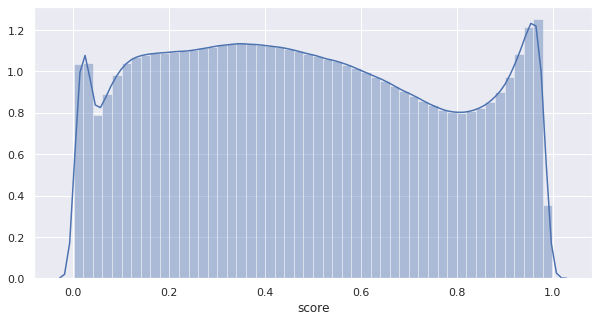

In [39]:
sns.distplot(df_score['score'])

- 위 분포가 맞는가.......
- 3월 결과 살펴봄

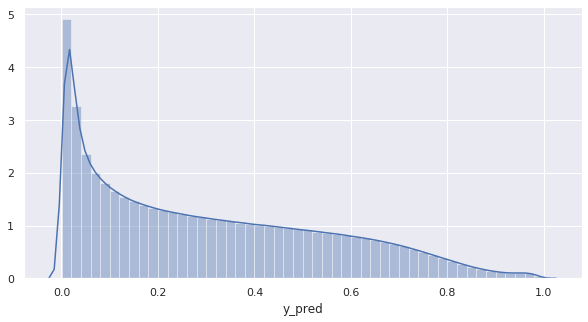

In [41]:
sns.distplot(df_result.y_pred)

### [check] 분포가 굉장히 다름... 
- 다른 월도 마찬가지
- 모델이 upsell 가능성을 높여준다고 생각하는 feature의 분포가 6월에 다르기 때문?

### 5. formating

In [53]:
df_score['prod_id'] = 'RC00000001'
df_score['prod_nm'] = '요금제업셀가망'
df_score['percent_rk'] = np.round(df_score.score.rank(pct=True, ascending=True), 4)
df_score['reco_type'] = 'upsell'
df_score['model'] = 'dominic_lgbm_20190709'
df_score['dt'] = '20190709'

/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [59]:
df_submit = df_score.copy()
df_submit.drop('score', inplace=True, axis=1)

df_submit.head()

### 6. load to hive

In [2]:
from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive

In [3]:
conn = hive_connection('dmig')

In [74]:
load_to_hive(conn,df_submit,"dumbo.upsell_predict_dominic")

2019-07-09 11:11:24,316 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.upsell_predict_dominic (                        svc_mgmt_num string, prod_id string, prod_nm string, percent_rk double, reco_type string, model string, dt string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-07-09 11:11:24,336 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-07-09 11:12:24,210 - YE_HIVE - INFO - Loading data to HDFS... 
2019-07-09 11:12:44,949 - YE_HIVE - INFO - Loading to table dumbo.upsell_predict_dominic is done


#### 7. 위 table 확인 후, 잘 들어가 있으면 아래 sql을 이용해 insert!

In [20]:
load_to_hive(conn, df_meta[['prod_id', 'item_nm', 'item_id']], 'dumbo.meta_for_vas_new_dominic')

2019-07-17 13:58:43,737 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.meta_for_vas_new_dominic (                        prod_id string, item_nm string, item_id string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-07-17 13:58:43,756 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-07-17 13:58:43,758 - YE_HIVE - INFO - Loading data to HDFS... 
2019-07-17 13:58:50,556 - YE_HIVE - INFO - Loading to table dumbo.meta_for_vas_new_dominic is done


In [ ]:
INSERT  OVERWRITE TABLE comm.item_reco_predict PARTITION (reco_type, model, dt)
SELECT  *
FROM    dumbo.upsell_predict_dominic_updated
;

In [ ]:
select * from comm_dev.item_reco a where model='dominic_lgbm_20190709' limit 10;

In [66]:
df_submit.head()

svc_mgmt_num     prod_id  prod_nm  percent_rk reco_type  \
0   1000181902  RC00000001  요금제업셀가망      0.1912    upsell   
1   1000249506  RC00000001  요금제업셀가망      0.6947    upsell   
2   1000439203  RC00000001  요금제업셀가망      0.3845    upsell   
3   1000868610  RC00000001  요금제업셀가망      0.2182    upsell   
4   1002110303  RC00000001  요금제업셀가망      0.6502    upsell   

                   model      dt  
0  dominic_lgbm_20190709  201909  
1  dominic_lgbm_20190709  201909  
2  dominic_lgbm_20190709  201909  
3  dominic_lgbm_20190709  201909  
4  dominic_lgbm_20190709  201909

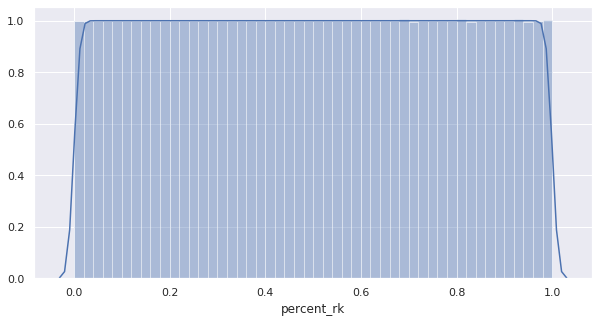

In [75]:
sns.distplot(df_submit.percent_rk)